### Binary Complete Neural Network

This notebook was created to test the conception of Binary Complete Convolution Networks and compare it with fully-precision networks and other approaches used in Binary Neural Networks

Importing all needed libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as tfms

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from datasets import load_dataset
from torchsummary import summary
from tqdm import tqdm
from src.models import ImageClassifier, BImageClassifier

Specifying CUDA if possible and setting multiprocessing start method to 'spawn', instead of 'fork', as it works better on UNIX-systems

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.multiprocessing.set_start_method('spawn', force=True)

Loading cifar10 dataset

In [3]:
cifar_ds = load_dataset('uoft-cs/cifar10')
cifar_train = cifar_ds['train']
cifar_test = cifar_ds['test']
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Checking samples

0
airplane


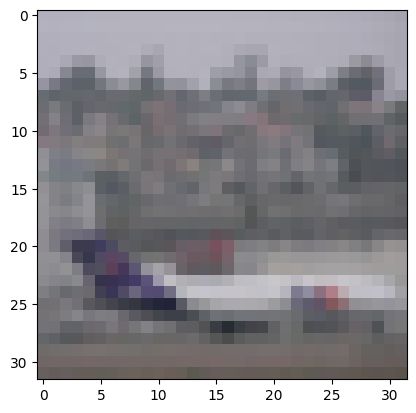

6
frog


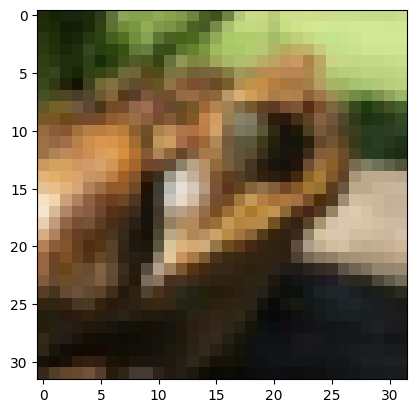

0
airplane


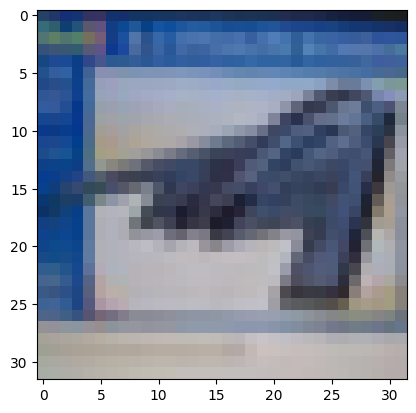

In [4]:
for i in range(3):
    sample = cifar_train[i]
    image = sample['img']
    label = sample['label']
    print(label)
    fig, ax = plt.subplots()
    print(class_names[label])
    #print(np.array(image))
    ax.imshow(image)
    plt.show()

In [5]:
transform_train = tfms.RandAugment()

Creating cifar10 dataset

In [6]:
class Cifar10Dataset(Dataset):
    def __init__(self, dataset : Dataset, transformation = None):
        super().__init__()
        self.dataset = dataset
        self.transformation = transformation

    def get_labeled(self, index : int):
        image, label = self.__getitem__(index)
        class_name = self.class_names[label]
        return image, class_name

    def __getitem__(self, index : int):
        sample = self.dataset[index]
        image = sample['img']
        if self.transformation is not None:
            image = self.transformation(image)
        image = np.array(image)
        label = sample['label']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [7]:
cifar_train_ds = Cifar10Dataset(cifar_train, transform_train)
cifar_test_ds = Cifar10Dataset(cifar_test)

Creating simple dataloader

In [8]:
BATCH_SIZE = 128

def collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        image = torch.Tensor(image).permute(2, 0, 1) # conv expects image as [channel, height, width] tensor
        images.append(image/255) # adding normalized image
        labels.append(label)
    images = torch.stack(images, dim=0).float()
    labels = torch.Tensor(labels).long()
    return images, labels

cifar_train_dataloader = DataLoader(cifar_train_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
cifar_test_dataloader = DataLoader(cifar_test_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, pin_memory=True)

Specifying loss

In [9]:
loss_fn = nn.CrossEntropyLoss()

Specifying Zhegalkin model

In [10]:
model = BImageClassifier((3, 32, 32), 50, len(class_names)).to(device)

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              GELU-1           [-1, 50, 31, 31]               0
   ConvAttention2d-2           [-1, 50, 31, 31]               0
         LayerNorm-3           [-1, 50, 31, 31]           1,922
  BConvAttention2d-4           [-1, 50, 31, 31]               0
         LayerNorm-5           [-1, 50, 31, 31]           1,922
  BConvAttention2d-6           [-1, 50, 31, 31]               0
         LayerNorm-7           [-1, 50, 31, 31]           1,922
  BConvAttention2d-8           [-1, 50, 31, 31]               0
         LayerNorm-9           [-1, 50, 31, 31]           1,922
 BConvAttention2d-10           [-1, 50, 31, 31]               0
        LayerNorm-11           [-1, 50, 31, 31]           1,922
 BConvAttention2d-12           [-1, 50, 31, 31]               0
        LayerNorm-13           [-1, 50, 31, 31]           1,922
 BConvAttention2d-14           [-1, 50,

In [11]:
history = {
    "train_loss" : [float('inf')],
    "train_acc" : [0],
    "val_loss" : [float('inf')],
    "val_acc" : [0]
}

In [12]:
def compute_accuracy(predictions: torch.Tensor, ground_truth: torch.Tensor) -> float:
    """
    Вычисляет точность предсказаний модели на CIFAR-10.

    Аргументы:
        predictions (torch.Tensor): Логиты сети (без softmax), размер [batch_size, num_classes].
        ground_truth (torch.Tensor): Истинные метки, размер [batch_size].

    Возвращает:
        float: Значение точности (accuracy) в процентах.
    """
    predicted_classes = predictions.argmax(dim=1)
    correct = (predicted_classes == ground_truth).sum().item()
    accuracy = correct / ground_truth.size(0)
    return accuracy

In [13]:
def train(model, dataloader, optimizer, coef : float, scheduler = None, accumulation_steps : int = 2):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.3f}, acc: {history['train_acc'][-1]:.3f}")
    total_loss = 0
    total_acc = 0
    out_of_mem = 0
    coef = torch.tensor([coef]).to(device)
    #coef = 1 + epoch//5
    #t = torch.tensor([coef/math.log(30 + coef)]).to(device)
    #k = torch.tensor([1 + 10*math.exp(1 - math.sqrt(coef))]).to(device)

    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        try:
            prediction = model(images, coef)
            loss_value = loss_fn(prediction, labels)
            loss_value.backward()

            if (batch_idx+1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            with torch.no_grad():
                cur_acc = compute_accuracy(prediction, labels)

            total_loss += loss_value.item()
            total_acc += cur_acc
            if batch_idx % 10 == 0:
                pbar.set_description(f"Train loss: {loss_value.item():.3f}, acc: {cur_acc:.3f}")

        except RuntimeError as e:
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e

        del images, labels
    if scheduler:
        scheduler.step(loss_value)
        print(scheduler.get_last_lr())
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    mean_loss = total_loss/(batch_idx+1)
    history['train_loss'].append(mean_loss)
    mean_acc = total_acc/(batch_idx + 1)
    history['train_acc'].append(mean_acc)
    return mean_loss, mean_acc

def test(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Test loss: {history['test_loss'][-1]:.3f}")
    total_loss = 0
    out_of_mem = 0
    acc_batch = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            try:
                prediction = model(images)
                acc_batch.append(compute_accuracy(prediction, labels))
                loss_value = loss_fn(prediction, labels)

            except RuntimeError as e:
                if 'out of memory' in str(e):
                    out_of_mem += 1
                    torch.cuda.empty_cache()
                else:
                    raise e

            total_loss += loss_value.item()
            if batch_idx % 10 == 0:
                history['test_loss'].append(loss_value.item())
                pbar.set_description(f"Test loss: {history['test_loss'][-1]:.3f}")

            del images, labels
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches")
    return total_loss/(batch_idx+1),

In [14]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

In [15]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2305410


In [ ]:
EPOCHS = 200
#best_val_loss = float('inf')

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    coef = 1 - (i//20*20)/(EPOCHS)
    train_loss, train_acc = train(model, cifar_train_dataloader, optimizer, coef, scheduler)
    print(f"Average training loss: {train_loss:.3f}, train accuracy: {train_acc:.3f}")
    #val_loss, val_acc = validate(model, cifar_test_dataloader)
    #print(f"Average test loss: {val_loss:.3f}, test accuracy: {val_acc:.3f}")
    print("-"*32)


Training epoch: 1/200


Train loss: 2.320, acc: 0.250: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]


[0.0001]
Average training loss: 2.396, train accuracy: 0.150
--------------------------------
Training epoch: 2/200


Train loss: 2.493, acc: 0.138: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


[0.0001]
Average training loss: 2.372, train accuracy: 0.153
--------------------------------
Training epoch: 3/200


Train loss: 2.252, acc: 0.212: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


[0.0001]
Average training loss: 2.355, train accuracy: 0.157
--------------------------------
Training epoch: 4/200


Train loss: 2.274, acc: 0.175: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


[0.0001]
Average training loss: 2.332, train accuracy: 0.161
--------------------------------
Training epoch: 5/200


Train loss: 2.289, acc: 0.250: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]


[0.0001]
Average training loss: 2.311, train accuracy: 0.170
--------------------------------
Training epoch: 6/200


Train loss: 2.359, acc: 0.150: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]


[0.0001]
Average training loss: 2.311, train accuracy: 0.171
--------------------------------
Training epoch: 7/200


Train loss: 2.177, acc: 0.200: 100%|██████████| 391/391 [01:01<00:00,  6.34it/s]


[0.0001]
Average training loss: 2.280, train accuracy: 0.179
--------------------------------
Training epoch: 8/200


Train loss: 2.342, acc: 0.113: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]


[0.0001]
Average training loss: 2.271, train accuracy: 0.182
--------------------------------
Training epoch: 9/200


Train loss: 2.312, acc: 0.150: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


[0.0001]
Average training loss: 2.260, train accuracy: 0.186
--------------------------------
Training epoch: 10/200


Train loss: 2.171, acc: 0.150: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]


[0.0001]
Average training loss: 2.245, train accuracy: 0.189
--------------------------------
Training epoch: 11/200


Train loss: 2.412, acc: 0.138: 100%|██████████| 391/391 [01:01<00:00,  6.37it/s]


[0.0001]
Average training loss: 2.223, train accuracy: 0.197
--------------------------------
Training epoch: 12/200


Train loss: 2.301, acc: 0.100: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


[0.0001]
Average training loss: 2.224, train accuracy: 0.198
--------------------------------
Training epoch: 13/200


Train loss: 2.186, acc: 0.212: 100%|██████████| 391/391 [01:01<00:00,  6.35it/s]


[0.0001]
Average training loss: 2.208, train accuracy: 0.205
--------------------------------
Training epoch: 14/200


Train loss: 2.261, acc: 0.212: 100%|██████████| 391/391 [01:01<00:00,  6.33it/s]


[0.0001]
Average training loss: 2.189, train accuracy: 0.208
--------------------------------
Training epoch: 15/200


Train loss: 2.214, acc: 0.188: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


[0.0001]
Average training loss: 2.191, train accuracy: 0.210
--------------------------------
Training epoch: 16/200


Train loss: 2.183, acc: 0.287: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


[0.0001]
Average training loss: 2.178, train accuracy: 0.212
--------------------------------
Training epoch: 17/200


Train loss: 2.230, acc: 0.138: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


[0.0001]
Average training loss: 2.164, train accuracy: 0.218
--------------------------------
Training epoch: 18/200


Train loss: 2.177, acc: 0.163: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]


[0.0001]
Average training loss: 2.155, train accuracy: 0.225
--------------------------------
Training epoch: 19/200


Train loss: 2.167, acc: 0.163: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]


[0.0001]
Average training loss: 2.151, train accuracy: 0.221
--------------------------------
Training epoch: 20/200


Train loss: 2.157, acc: 0.211:  18%|█▊        | 70/391 [00:10<00:49,  6.50it/s]

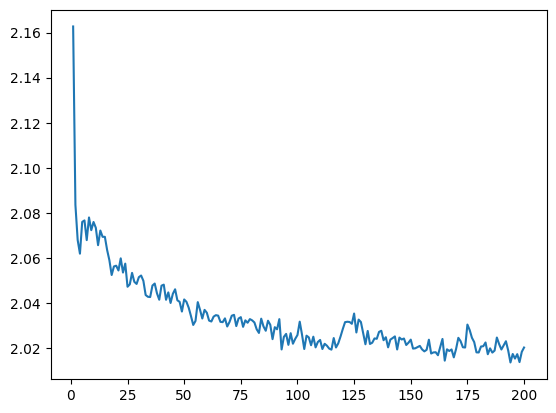

In [ ]:
plt.plot(history['train_loss'])